In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(ptotallengths,gtotallengths,
                num_pconnections, num_gconnections, num_fpconnections, num_fgconnections):
    if num_fpconnections + num_fgconnections < 2:
        return "ucf"
    elif num_pconnections == 1 and num_gconnections ==0:# and num_mconnections==4: #gtotallengths>48
        return "p"
    elif num_pconnections == 0 and num_gconnections ==1:# and num_mconnections == 4:
        return "g"
    elif num_pconnections == 1 and num_gconnections ==1:# and num_mconnections ==3:
        return "b"
    else:
        return "ucf"
    
def connect(cv, radii, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    num_f_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_d = vector_dist(cv, cv2)
        total_separations += vector_d
        r1,r2 = radii
        if vector_d <= 2*r1 and vector_d > .2*r1: # blob centers closer than diameter of one blob
            num_connections += 1
        if vector_d <= 2*r2 and vector_d > .2*r1: # blob centers closer than diameter of one blob
            num_f_connections += 1
        else:
            pass
        if vector_d <= 4*r1: 
            normalized_dists.append(vector_d/(2*norm_radius))
    return ([num_connections, num_f_connections], normalized_dists, total_separations)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
connect_test = connect((0, 0),(2, 2), [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

([1, 1], [0.1, 0.1414213562373095, 0.0], 19.97056274847714) [5.0, 10.0] hello


In [4]:
grp1 = [1, [95, 67], 2]
grp2 = [2, [9.0], 13]
print(grp1+grp2)
print([grp1[i]+grp2[i] for i in range(len(grp1))])

[1, [95, 67], 2, 2, [9.0], 13]
[3, [95, 67, 9.0], 15]


In [5]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    p_bond = 15*1
    g_bond = 15*.95
    fp_bond = 15*1.4
    fg_bond = 15*1.5
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        
        phighlight = morphology.binary_opening(thresh_img, disk(9))
        img = np.copy(frame)
        img[phighlight==0] = 0
        pblobs =skimage.feature.blob_doh(img, min_sigma =8, max_sigma = 16, threshold = 0.008, num_sigma= 15, overlap=0.5)
        
        ghighlight = gaussian(
        opening(
             (thresh_img^phighlight)
                           , disk(2)), sigma = 0.65)
        
        img = np.copy(frame)
        img[ghighlight==0] = 0
        gblobs =skimage.feature.blob_doh(img, min_sigma =7, max_sigma = 16, threshold = 0.012)
    
        
        blobset.append([pblobs, gblobs])
        ngblobs = len(gblobs)
        npblobs = len(pblobs)         
        blobs = np.vstack((gblobs, pblobs  ))
        num_blobs = len(blobs)
        
        """plas_on_glas_dists =[connect((pblob[1], pblob[0]),m_bond, gblobs) for pblob in pblobs]
        plas_on_glas_dists = [sum([pog[0] for pog in plas_on_glas_dists]), 
                              list(chain(*[pog[1] for pog in plas_on_glas_dists])),
                             sum([pog[2] for pog in plas_on_glas_dists])]
        num_mconnections = plas_on_glas_dists[0]
        mdistances = plas_on_glas_dists[1]
        mtotallengths = plas_on_glas_dists[2]"""
        
        glas_on_glas_dists =[connect((gblobs[i][1], gblobs[i][0]),(g_bond, fg_bond), gblobs[i+1:]) for i in range(ngblobs-1)]
        glas_on_glas_dists = [[sum([gog[0][0] for gog in glas_on_glas_dists]), sum([gog[0][1] for gog in glas_on_glas_dists])], 
                              list(chain(*[gog[1] for gog in glas_on_glas_dists])),
                             sum([gog[2] for gog in glas_on_glas_dists])]
        num_gconnections,num_fgconnections  = glas_on_glas_dists[0]
        gdistances = glas_on_glas_dists[1]
        gtotallengths = glas_on_glas_dists[2]
        
        plas_on_plas_dists = [connect((pblobs[i][1], pblobs[i][0]),(p_bond, fp_bond), pblobs[i+1:]) for i in range(npblobs-1)]
        plas_on_plas_dists = [[sum([pop[0][0] for pop in plas_on_plas_dists]), sum([pop[0][1] for pop in plas_on_plas_dists])], 
                              list(chain(*[pop[1] for pop in plas_on_plas_dists])),
                             sum([pop[2] for pop in plas_on_plas_dists])]
        num_pconnections, num_fpconnections = plas_on_plas_dists[0]
        pdistances = plas_on_plas_dists[1]
        ptotallengths = plas_on_plas_dists[2]
        
        
        
        num_opconnections = sum([num_pconnections, num_gconnections])#,num_mconnections])
        distances = list(chain(pdistances, gdistances))       
        totallengths = sum([ptotallengths, gtotallengths])
        
        #----------------------filter------------------------- can use actual filter
        properties = {'num_blobs':num_blobs,
                      'num_pblobs':npblobs,
                      'num_gblobs':ngblobs,
                      'num_opconnections': num_opconnections,
                      'num_pconnections':num_pconnections, 
                      'num_gconnections':num_gconnections, 
                      'num_fpconnections':num_fpconnections,
                      'num_fgconnections':num_fgconnections,
                     'totallengths':totallengths, 
                      'ptotallengths':ptotallengths, 
                      'gtotallengths':gtotallengths, 
                     'distances':distances, 
                      'pdistances':pdistances, 
                      'gdistances':gdistances}
        #print(properties)
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = True#(num_connections >= expected_connections and num_blobs>=expected_blobs)
        if test: 
            #-----------------------------classify pt 1---------------------------------------
            clas = sideify(ptotallengths,gtotallengths,
                num_pconnections,num_gconnections, num_fpconnections, num_fgconnections)
            filtrate_prop.append(properties)
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






In [6]:
filenames = glob("./tchakamau/Real*half/*0.avi")#glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 5
Pass_ratios = np.zeros((len(filenames), num_shape_cats))

"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames = {"p" : list(range(1222, 2022, 4)),
                  "g" :[], 
                  "b" :list(range(3358, 4358, 5)), 
                 "broken" :list(range(306, 1018, 3)) ,
                 "odd_s" :[] }

"""phantom_frames_3 = {"t" :list(range(30104, 29591, -1)),
                  "c" :list(range(30816, 30375, -2)), 
                 "broken" :list(range(30340, 30288, -1)) ,
                 "odd_s" :[]}"""
phantom_frame_sets = [phantom_frames]
trigger_frames = [1]


['./tchakamau\\Real_glass_half\\45672_15Vpp_0.avi']


In [7]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["p", "g", "b", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if abs(tf-frameindex) in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], abs(tf-frameindex)))
           
        frameindex += 1
    
    
""" for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        
        frames = 
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])
"""

<generator object vreader at 0x000001CAD068A748>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

In [8]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i])
    fil = len(x[0])
    pas = len(x[1])
    print(orig, fil, pas)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", pas*100/orig)
        p_rats.append(pas*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

200 200 143
p _vid
original_vid:  200
filtrate:  200
pass ratio:  71.5


0 0 0
g _vid
original_vid:  0
filtrate:  0


200 200 133
b _vid
original_vid:  200
filtrate:  200
pass ratio:  66.5


0 0 0
odd_s _vid
original_vid:  0
filtrate:  0


238 238 232
broken _vid
original_vid:  238
filtrate:  238
pass ratio:  97.47899159663865


5 5 5


In [9]:
names = {'num_blobs':[],
                      'num_pblobs':[],
                      'num_gblobs':[],
                      'num_opconnections': [],
                      'num_pconnections':[], 
                      'num_gconnections':[], 
                      'num_fpconnections':[], 
                      'num_fgconnections':[],
                     'totallengths':[], 
                      'ptotallengths':[], 
                      'gtotallengths':[], 
                     'distances':[], 
                      'pdistances':[], 
                      'gdistances':[]}
strings = names.keys()
distances = [string for string in strings if 'distances' in string]
simplenames = strings - distances
print(distances, simplenames)

['distances', 'pdistances', 'gdistances'] {'num_blobs', 'num_fgconnections', 'num_pblobs', 'ptotallengths', 'gtotallengths', 'totallengths', 'num_gblobs', 'num_fpconnections', 'num_opconnections', 'num_gconnections', 'num_pconnections'}


num_blobs averages: 
p : 5 
g : nan 
b : 5 
odd_s : nan 
broken : 4 
num_blobs variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 1 
num_fgconnections averages: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 0 
num_fgconnections variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
num_pblobs averages: 
p : 2 
g : nan 
b : 2 
odd_s : nan 
broken : 3 
num_pblobs variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
ptotallengths averages: 
p : 174 
g : nan 
b : 166 
odd_s : nan 
broken : 285 
ptotallengths variances: 
p : 29658 
g : nan 
b : 31896 
odd_s : nan 
broken : 38855 
gtotallengths averages: 
p : 244 
g : nan 
b : 270 
odd_s : nan 
broken : 150 
gtotallengths variances: 
p : 42137 
g : nan 
b : 48856 
odd_s : nan 
broken : 49177 
totallengths averages: 
p : 418 
g : nan 
b : 435 
odd_s : nan 
broken : 435 
totallengths variances: 
p : 4060 
g : nan 
b : 6370 
odd_s : nan 
broken : 14350 
num_gblobs averages: 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)



p : 2 
g : nan 
b : 2 
odd_s : nan 
broken : 1 
num_gblobs variances: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 1 
num_fpconnections averages: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 1 
num_fpconnections variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
num_opconnections averages: 
p : 1 
g : nan 
b : 2 
odd_s : nan 
broken : 1 
num_opconnections variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
num_gconnections averages: 
p : 0 
g : nan 
b : 1 
odd_s : nan 
broken : 0 
num_gconnections variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
num_pconnections averages: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 1 
num_pconnections variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
200
349
distances averages: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 1 
distances variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
199
pdistances averages: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 1 
pdistances variances: 
p : 0 
g : nan 
b : 

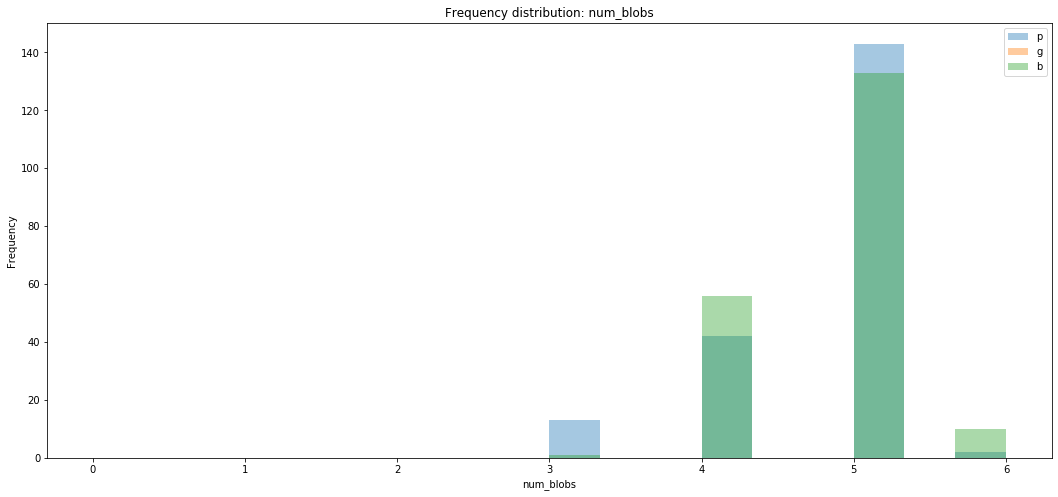

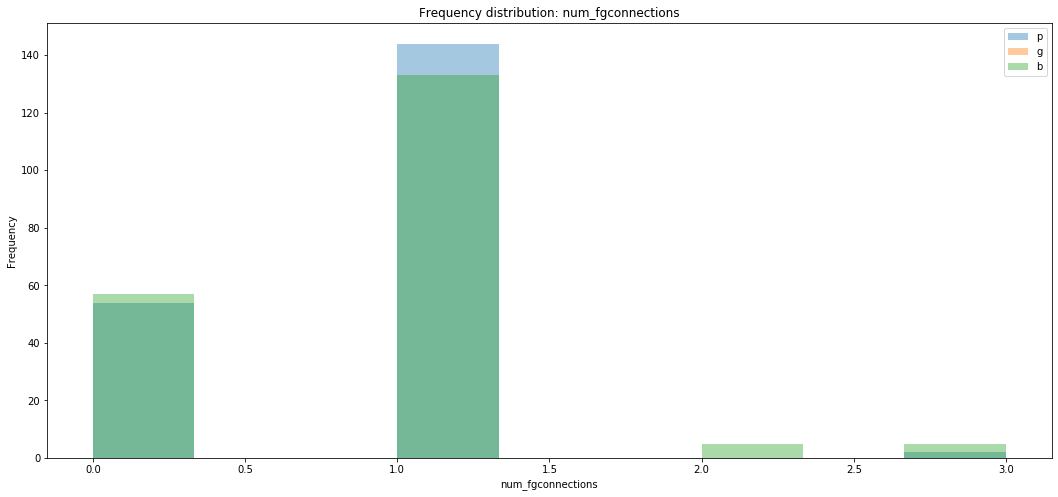

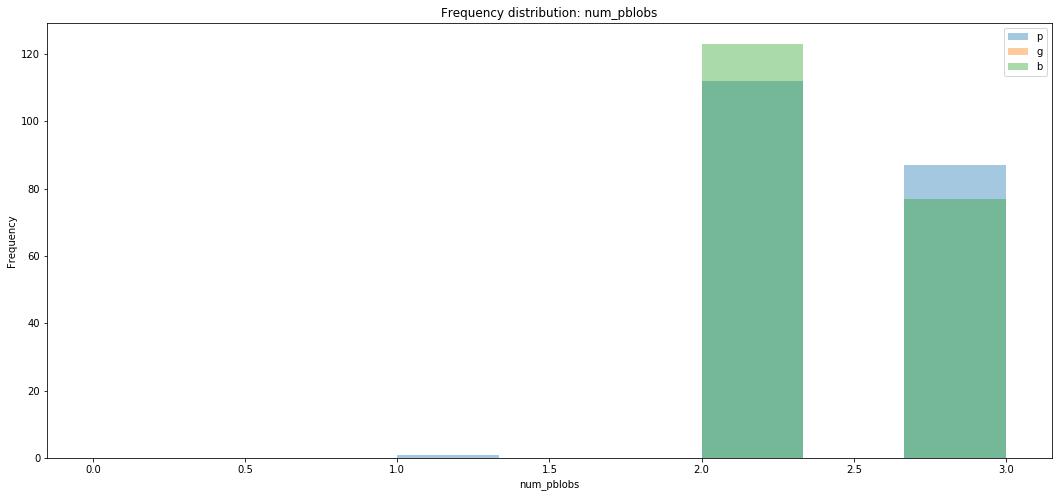

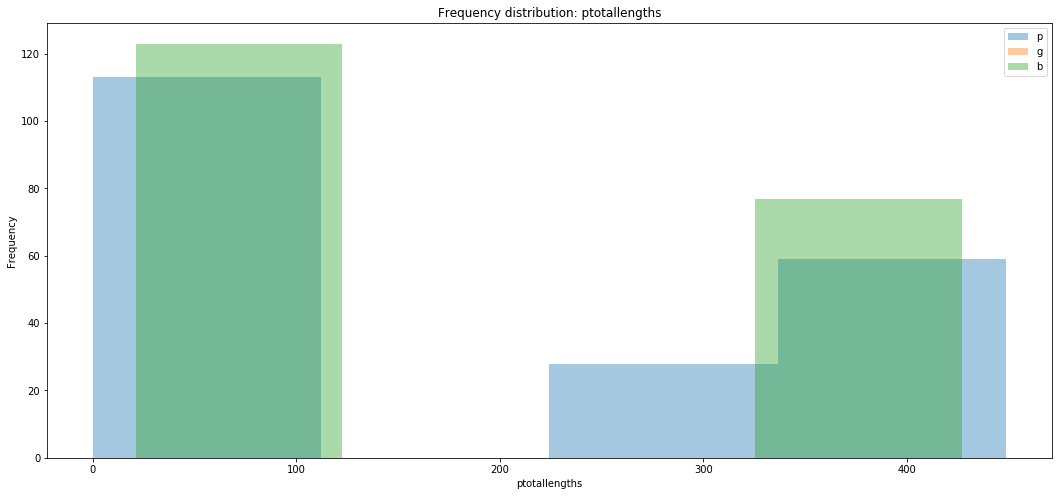

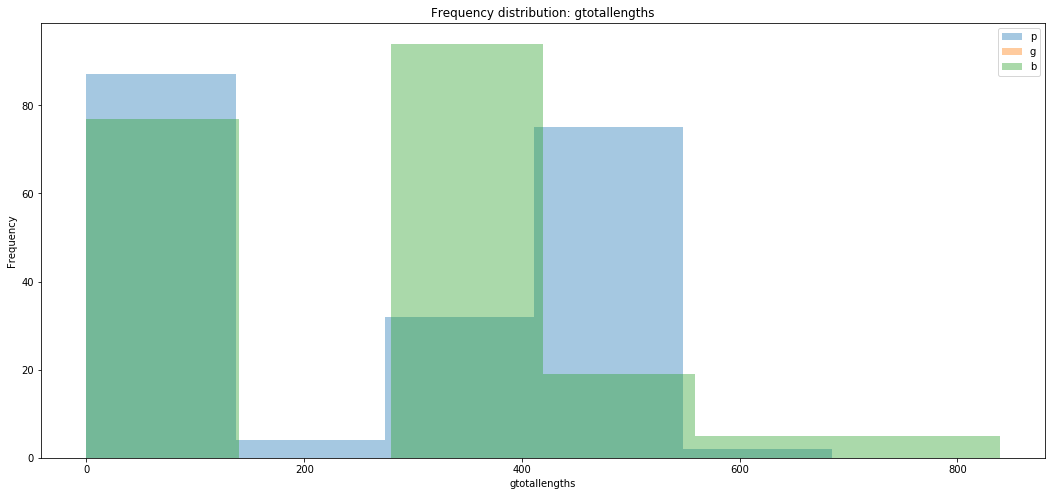

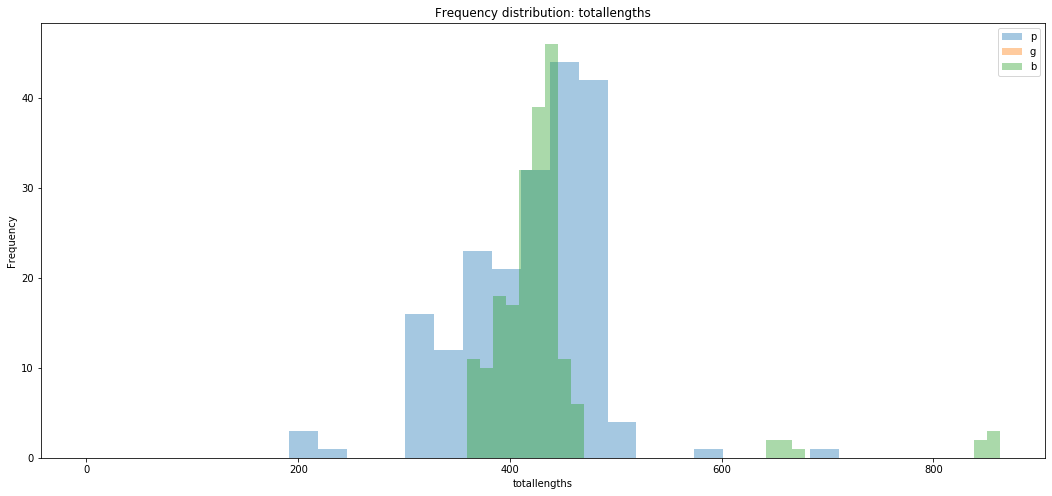

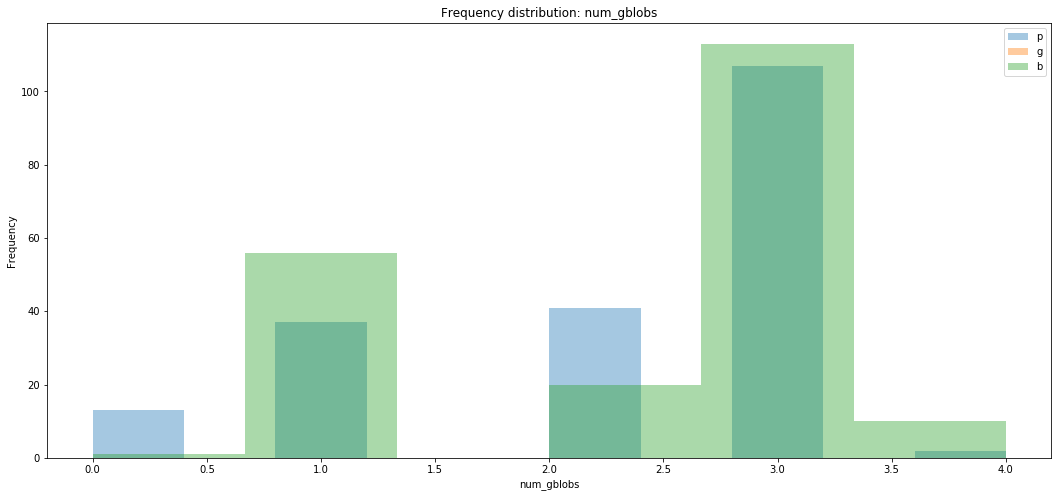

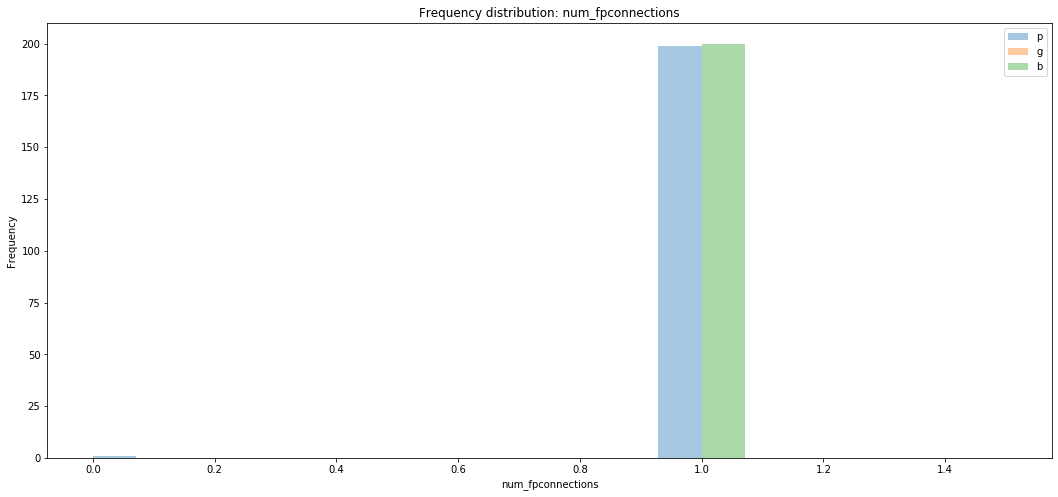

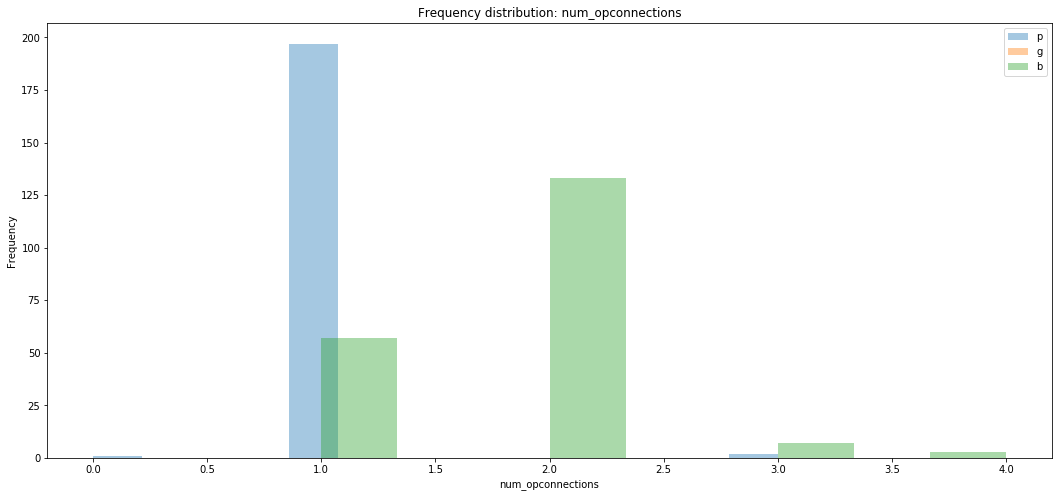

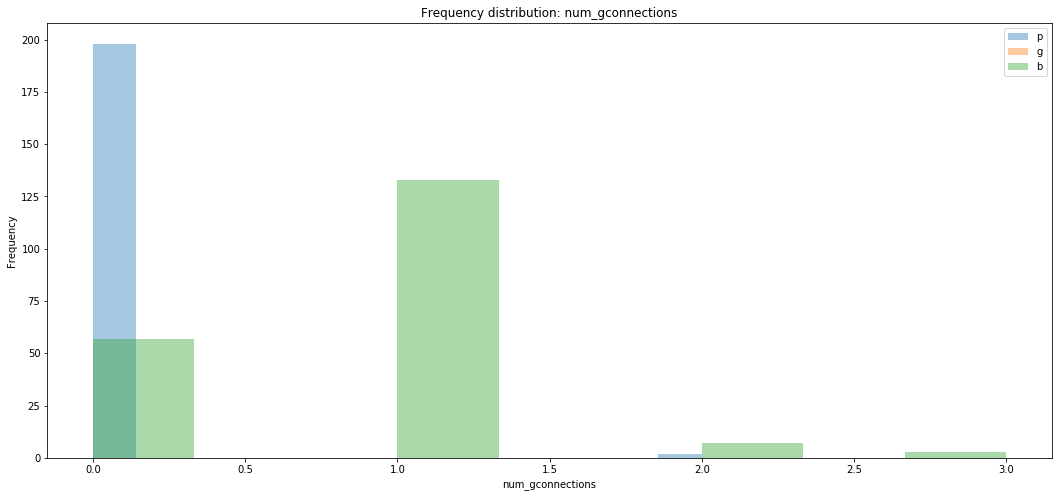

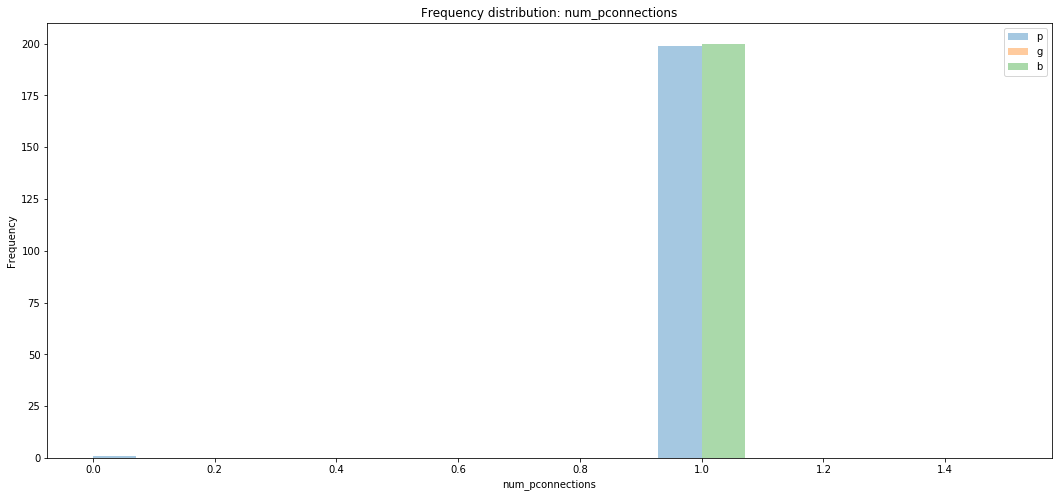

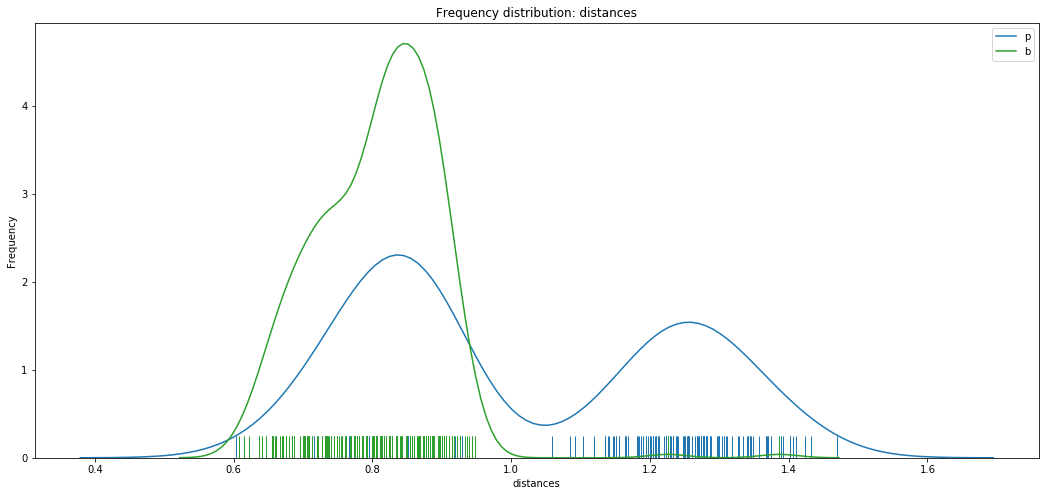

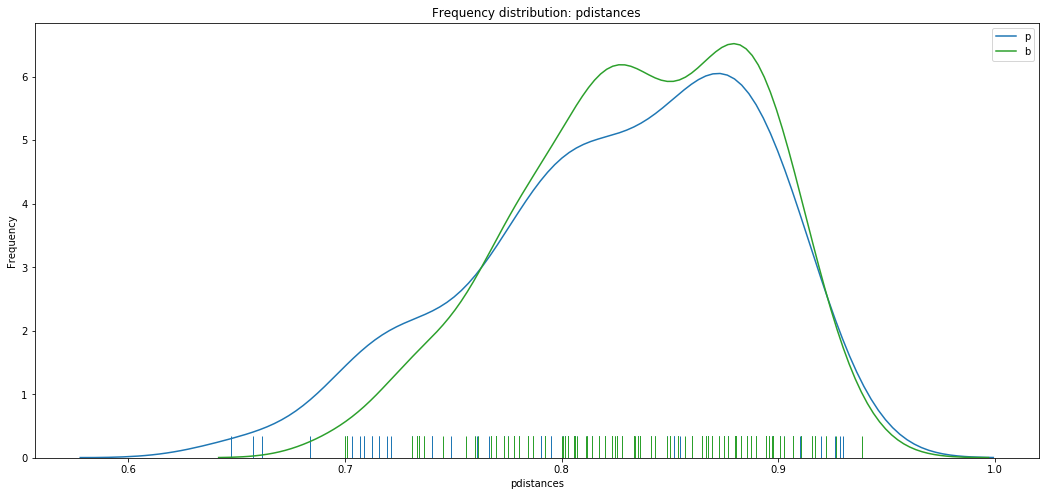

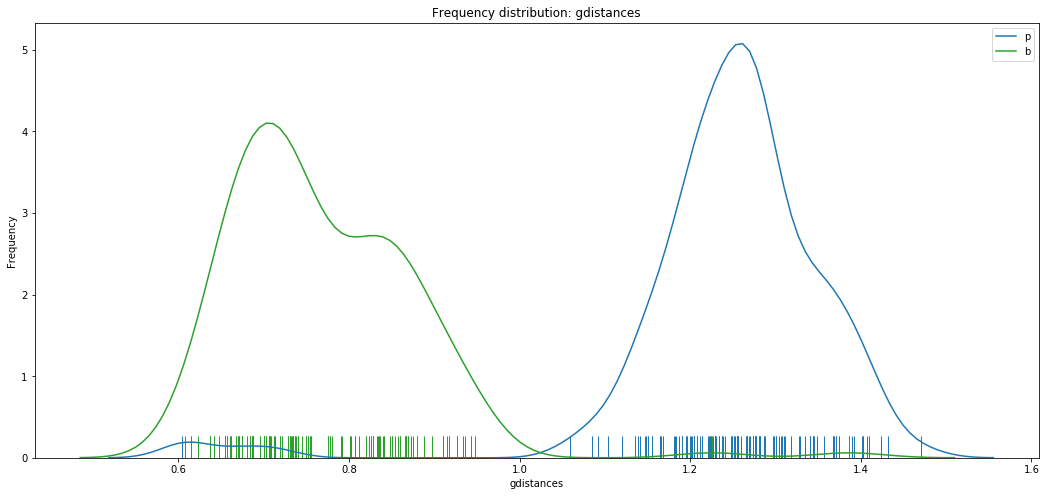

In [10]:
"""Everything"""

# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-2):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in a_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-2):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




num_blobs averages: 
p : 5 
g : nan 
b : 5 
odd_s : nan 
broken : 4 
num_blobs variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 1 
num_fgconnections averages: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 0 
num_fgconnections variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
num_pblobs averages: 
p : 2 
g : nan 
b : 2 
odd_s : nan 
broken : 3 
num_pblobs variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
ptotallengths averages: 
p : 174 
g : nan 
b : 166 
odd_s : nan 
broken : 285 
ptotallengths variances: 
p : 29658 
g : nan 
b : 31896 
odd_s : nan 
broken : 38855 
gtotallengths averages: 
p : 244 
g : nan 
b : 270 
odd_s : nan 
broken : 150 
gtotallengths variances: 
p : 42137 
g : nan 
b : 48856 
odd_s : nan 
broken : 49177 
totallengths averages: 
p : 418 
g : nan 
b : 435 
odd_s : nan 
broken : 435 
totallengths variances: 
p : 4060 
g : nan 
b : 6370 
odd_s : nan 
broken : 14350 
num_gblobs averages: 
p : 2 
g : nan 
b : 2 
odd_s : nan 
broken : 1 
num_

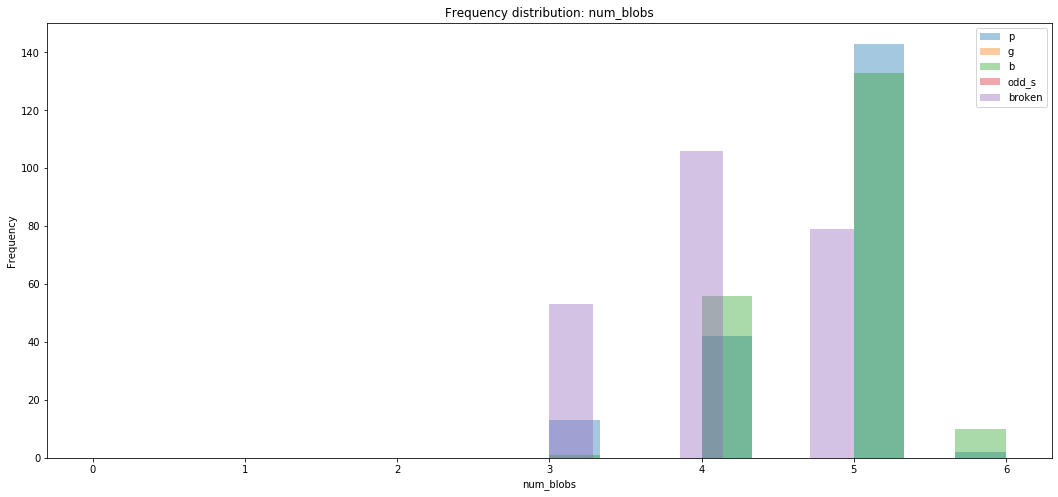

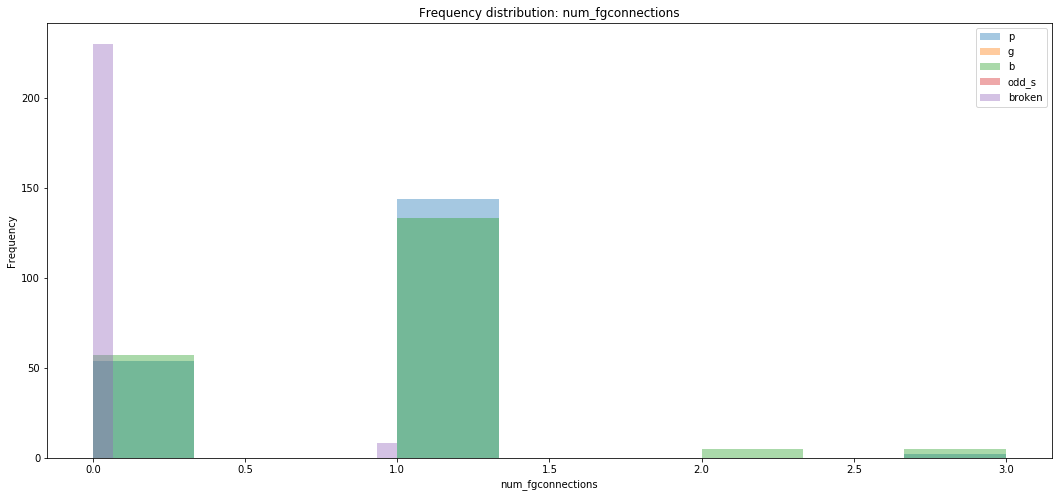

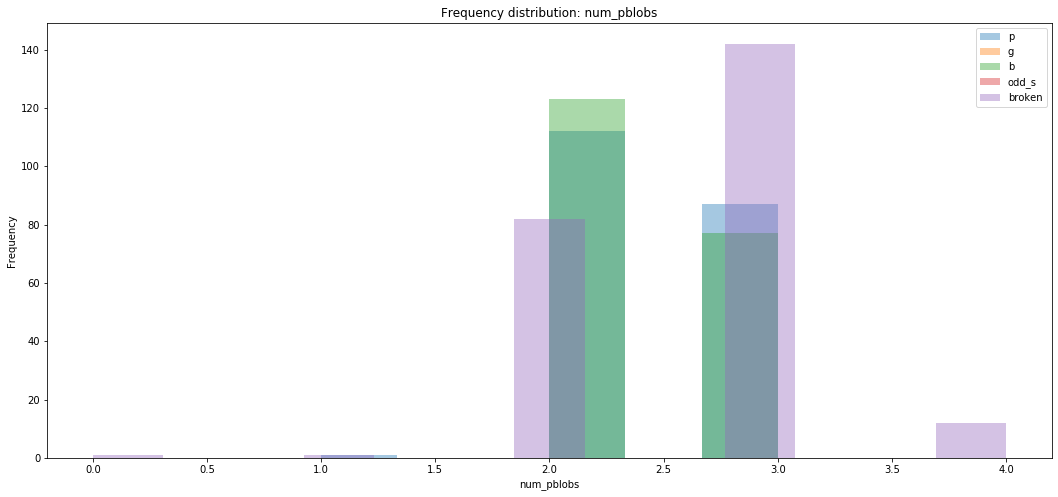

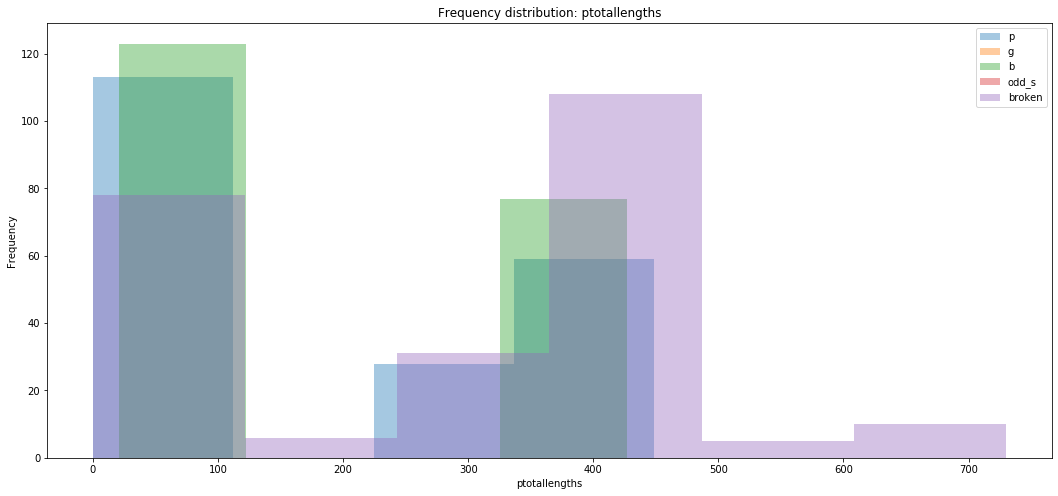

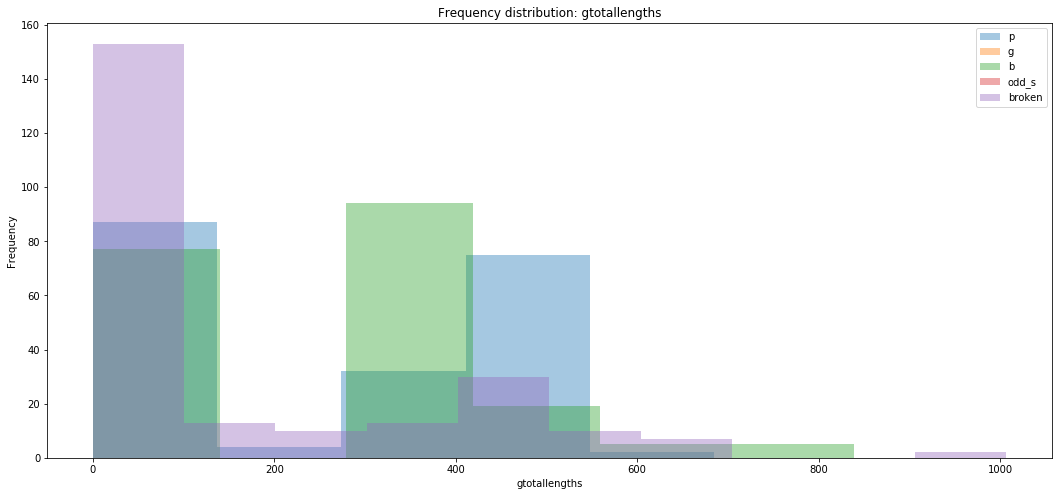

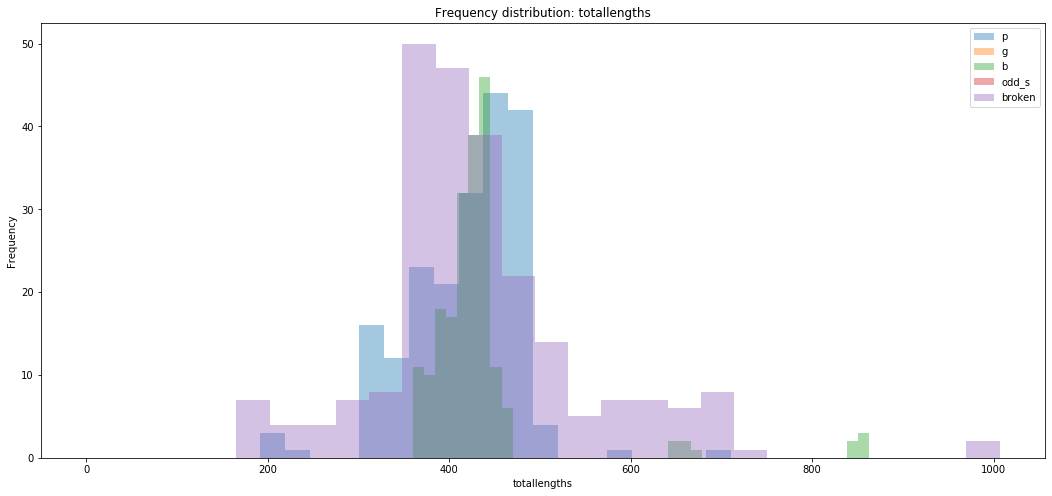

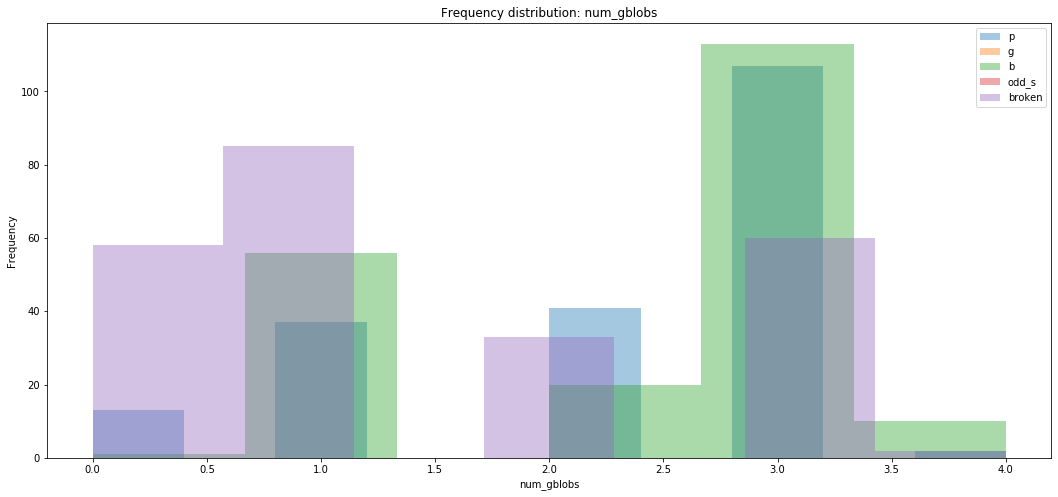

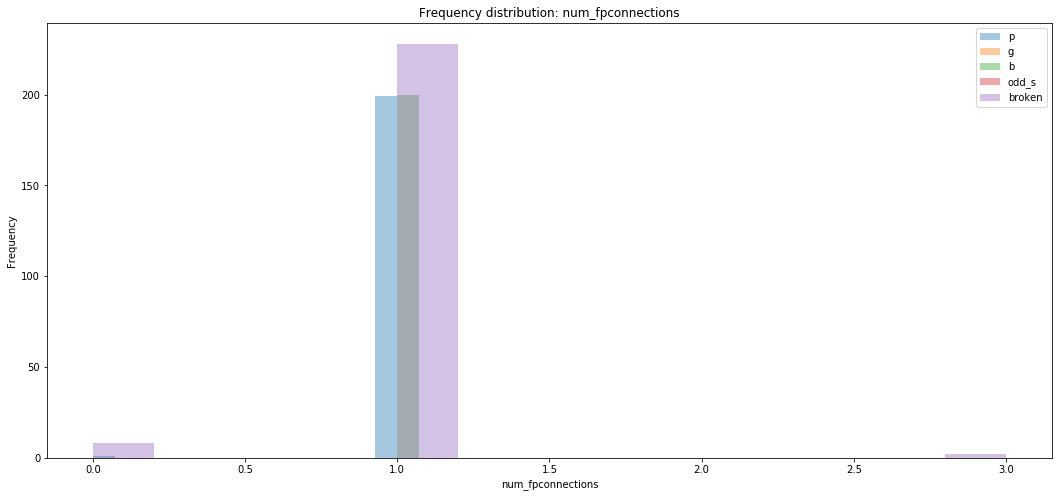

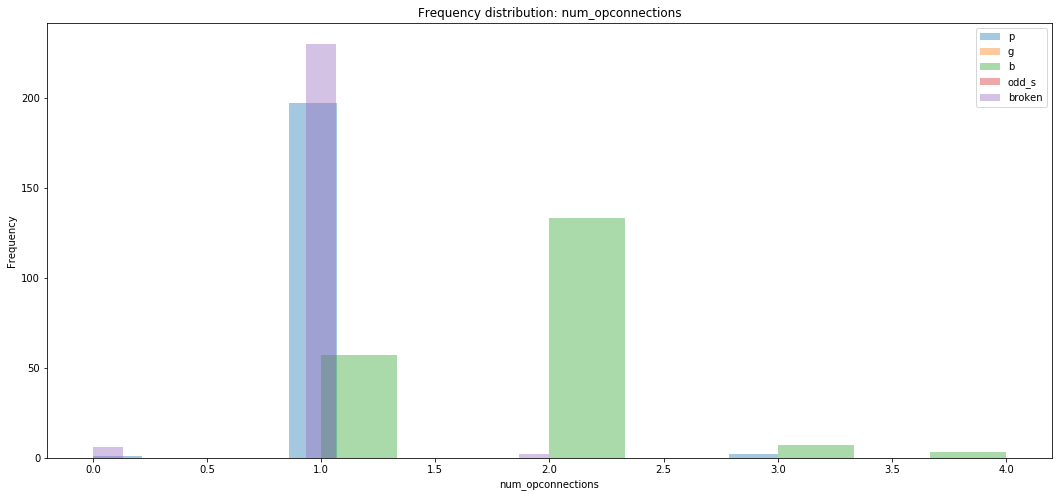

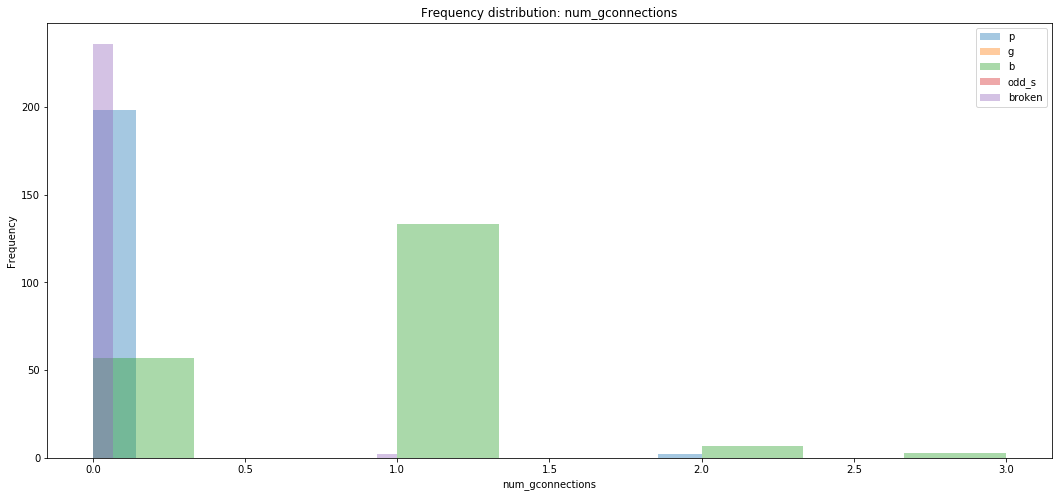

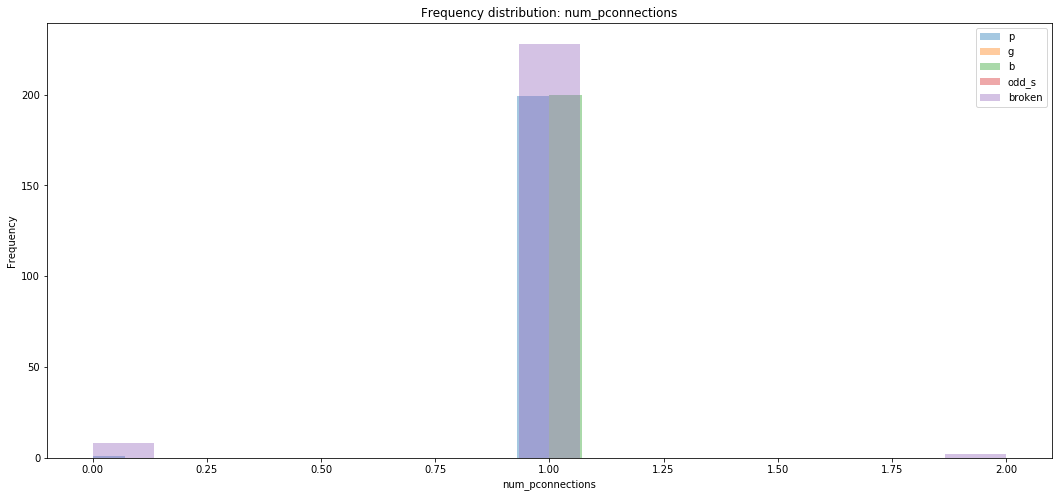

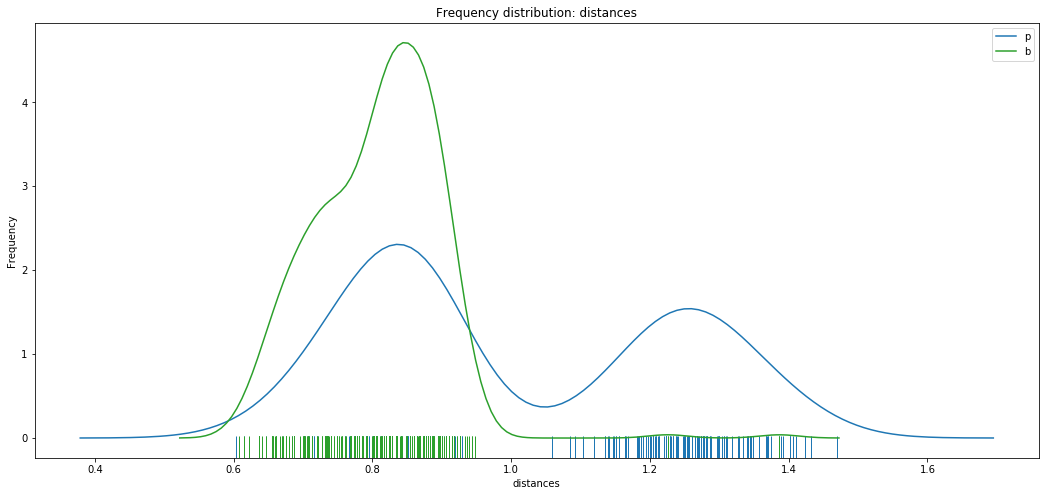

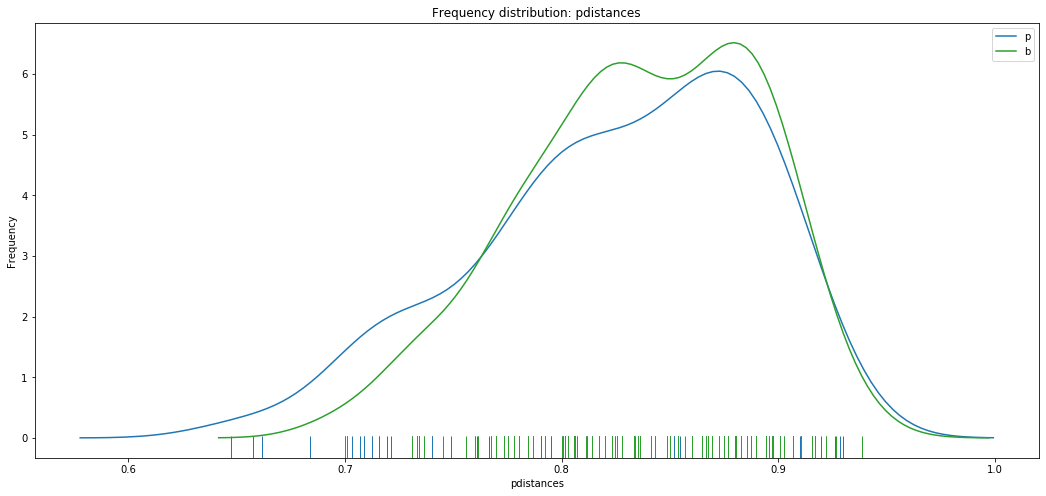

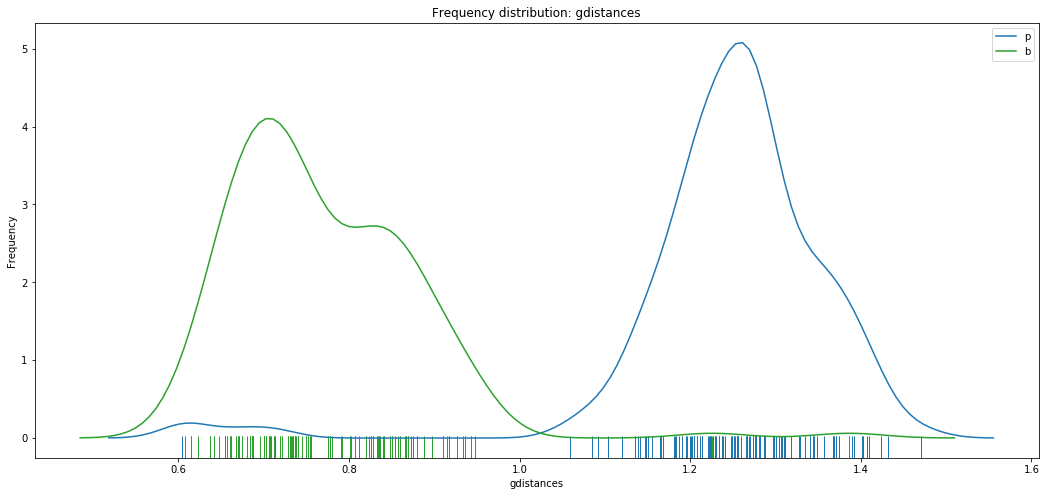

In [11]:
"""After first tests"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in filtrates_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



num_blobs averages: 
p : 5 
g : nan 
b : 5 
odd_s : nan 
broken : 4 
num_blobs variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 1 
num_fgconnections averages: 
p : 1 
g : nan 
b : 1 
odd_s : nan 
broken : 0 
num_fgconnections variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
num_pblobs averages: 
p : 2 
g : nan 
b : 2 
odd_s : nan 
broken : 3 
num_pblobs variances: 
p : 0 
g : nan 
b : 0 
odd_s : nan 
broken : 0 
ptotallengths averages: 
p : 117 
g : nan 
b : 79 
odd_s : nan 
broken : 291 
ptotallengths variances: 
p : 24968 
g : nan 
b : 16851 
odd_s : nan 
broken : 38052 
gtotallengths averages: 
p : 325 
g : nan 
b : 351 
odd_s : nan 
broken : 143 
gtotallengths variances: 
p : 29218 
g : nan 
b : 19117 
odd_s : nan 
broken : 48244 
totallengths averages: 
p : 442 
g : nan 
b : 430 
odd_s : nan 
broken : 434 
totallengths variances: 
p : 1299 
g : nan 
b : 272 
odd_s : nan 
broken : 14698 
num_gblobs averages: 
p : 3 
g : nan 
b : 3 
odd_s : nan 
broken : 1 
num_gb

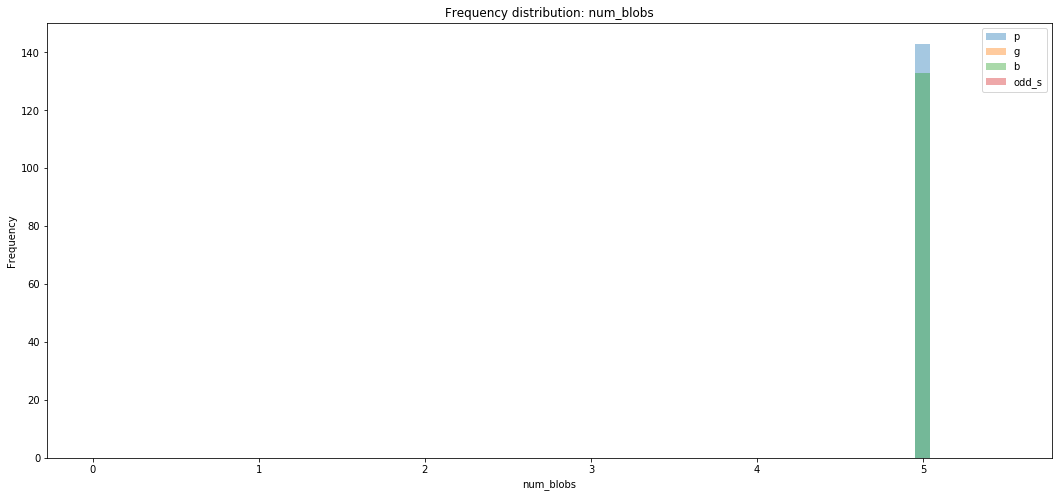

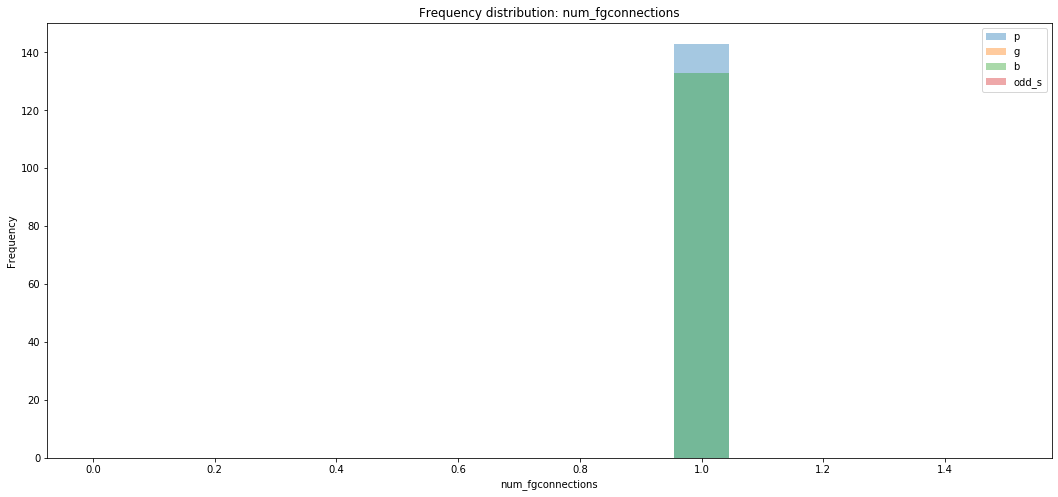

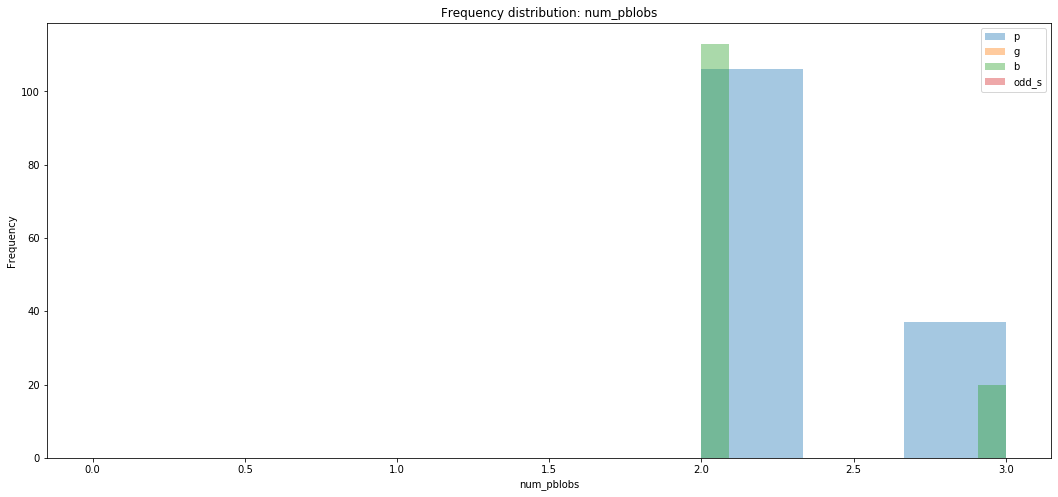

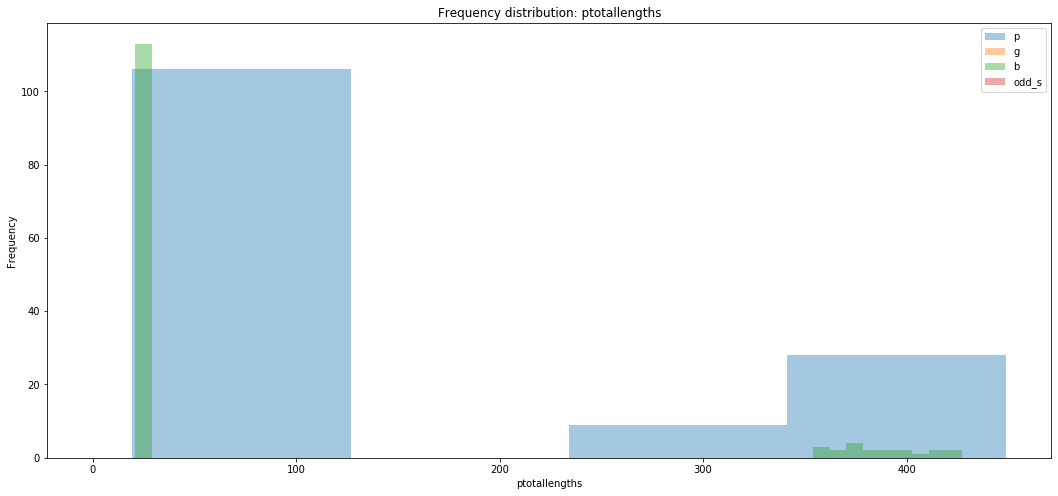

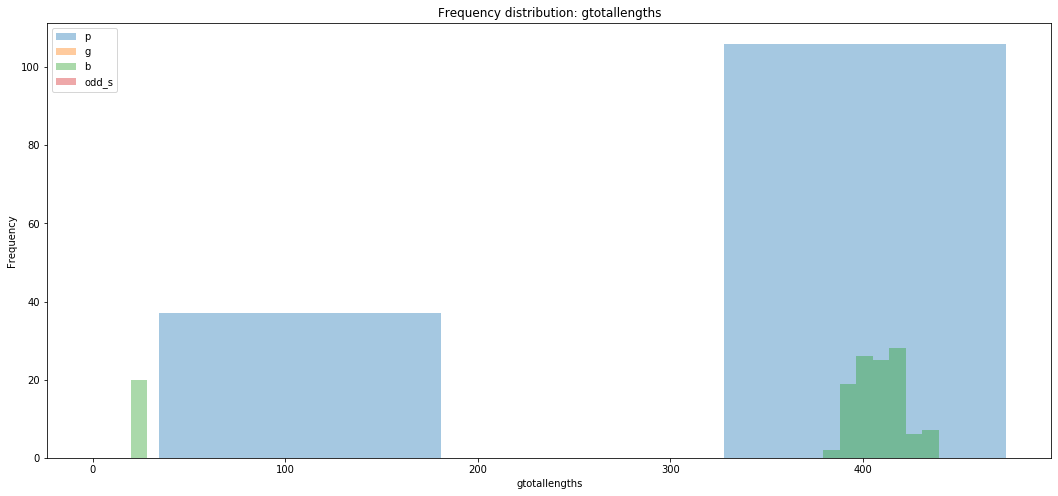

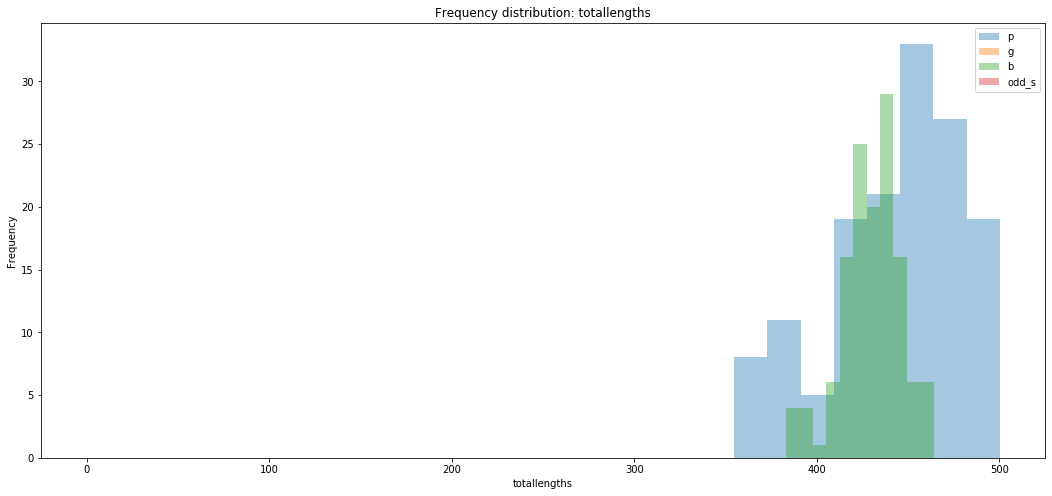

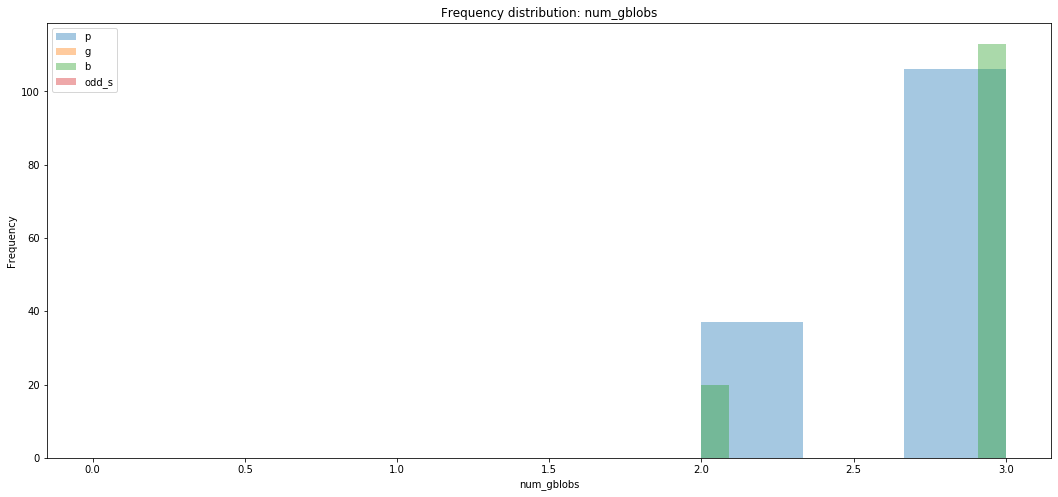

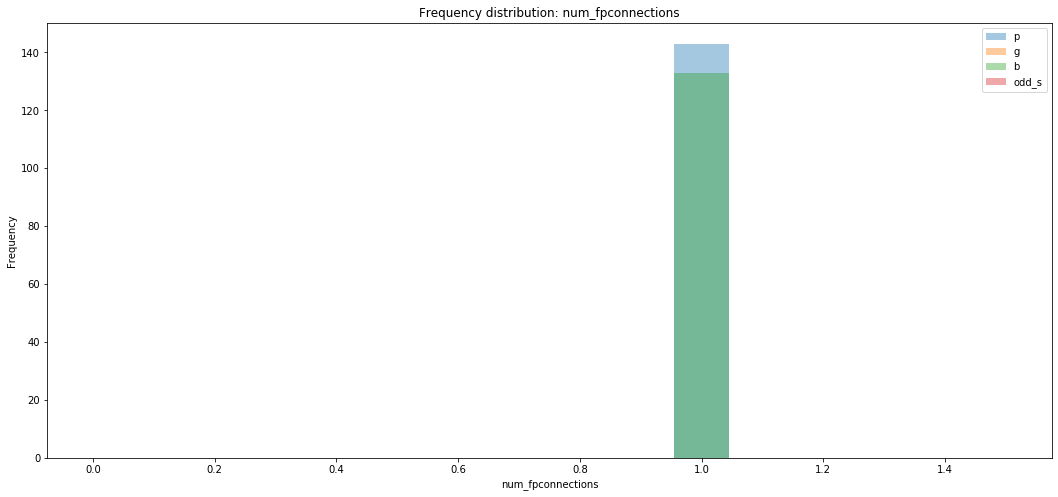

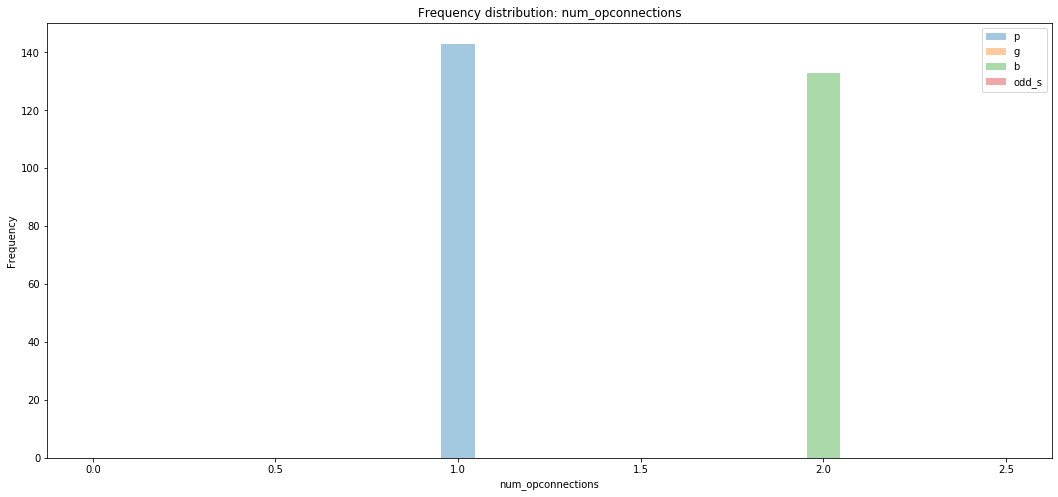

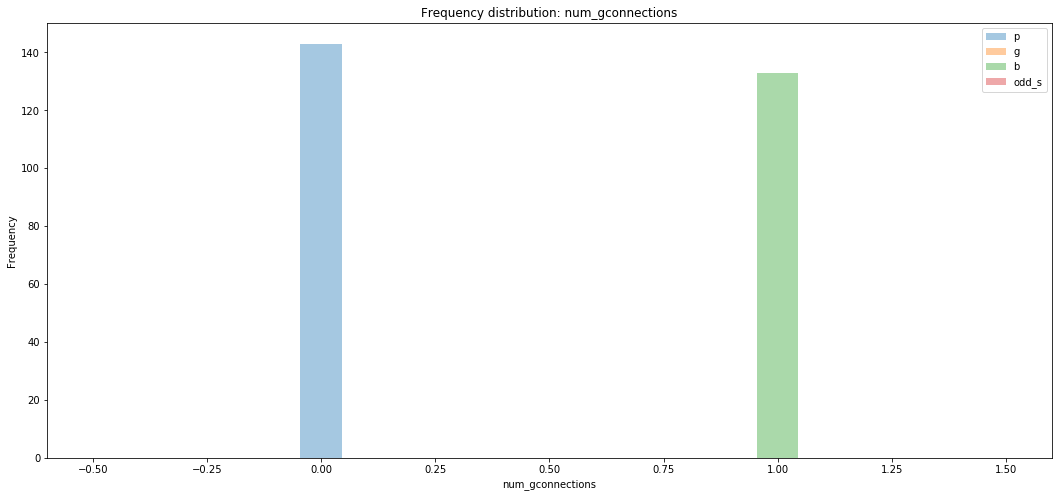

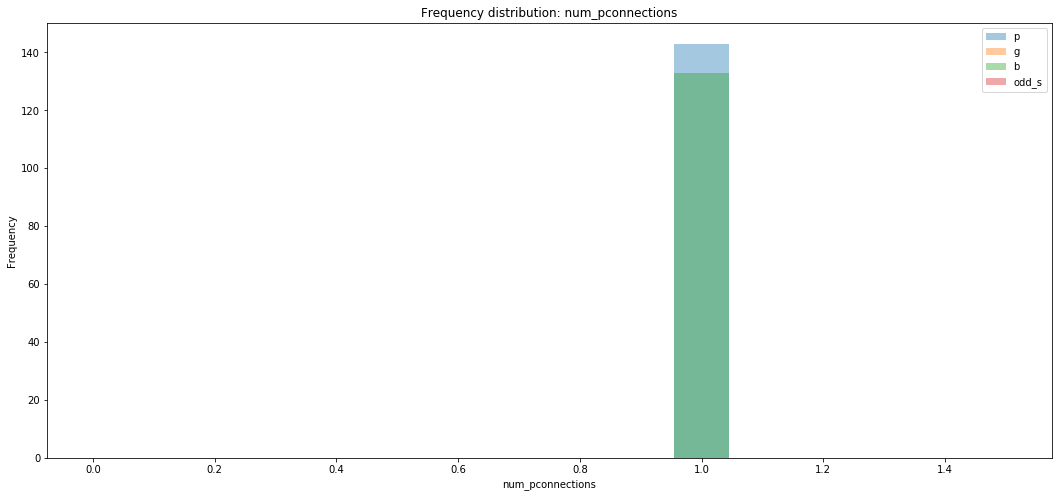

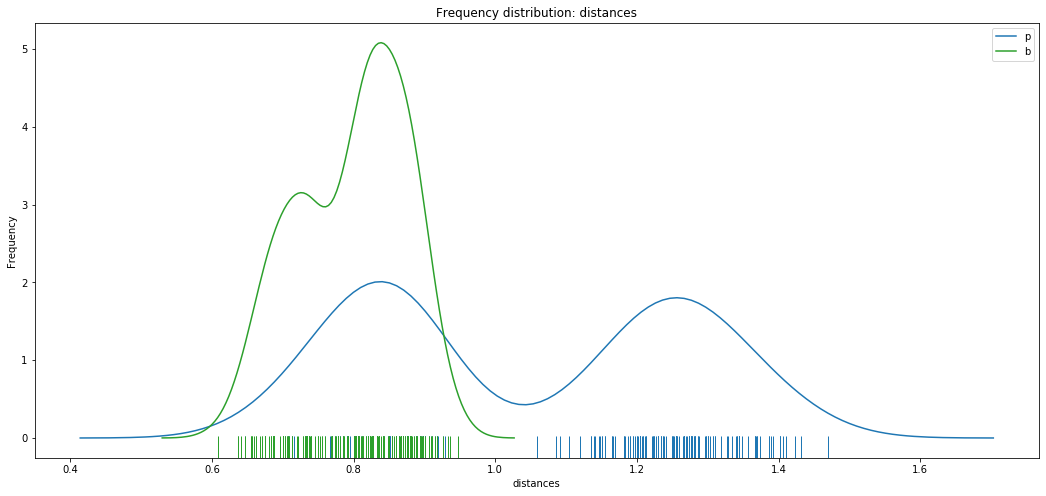

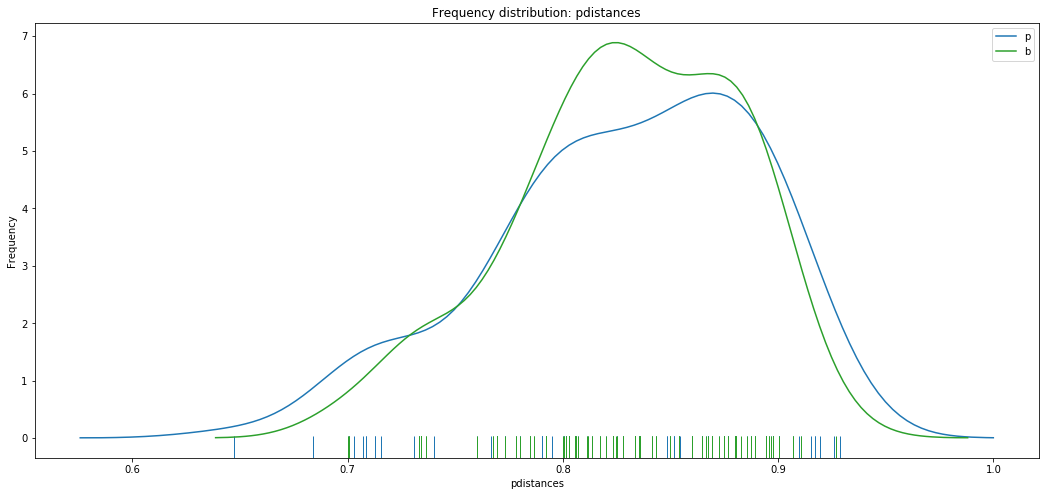

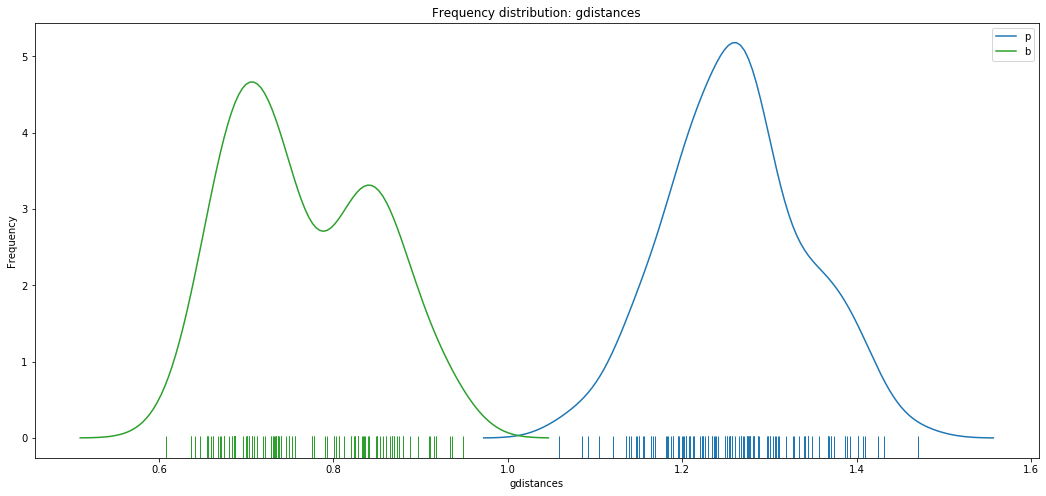

In [12]:

"""Correctly classified"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in passes[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
